# IEBS
### Proyecto fin de Postgrado
--- 
- Aplicacion
- Alumno: Gabriel Rey

## Librerias

In [1]:
import os
import sys
import pathlib
from datetime import datetime
import time

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display as ipd
from PIL import Image

import librosa
import librosa.display

import wave

In [2]:
import pyaudio
import speech_recognition as sr

In [1]:
from keras.models import load_model
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img

### Cargar el Modelo

In [9]:
model = load_model('modelo.h5')

ValueError: Unknown optimizer: Custom>Adam. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [5]:
clases = ['0000  RUIDO',
          '0413  COTORRA',
          '0562  CARPINTERO REAL',
          '0625  HORNERO',
          '0807  BENTEVEO COMÚN',
          '0879  GOLONDRINA DOMÉSTICA',
          '0899  ZORZAL COLORADO',
          '0903  CALANDRIA CALANDRE',
          '1024  JILGUERO DORADO',
          '1062  GORRIÓN',
          '1070  BOYERITO']

In [6]:
#model = load_model('pajaros09.h5')
#clases = ['0000  RUIDO',
#          '0807  BENTEVEO COMÚN',
#          '0879  GOLONDRINA DOMÉSTICA',
#          '0899  ZORZAL COLORADO',
#          '0903  CALANDRIA CALANDRE',
#          '1062  GORRIÓN',
#          '1070  BOYERITO']

### Cargar un archivo de Test (imagen)

In [7]:
cwd = os.getcwd()
cwd

'C:\\Users\\gabri\\Documents\\OneDrive\\Machine Learning\\Jupyter Notebooks\\Redes Neuronales\\AUDIO\\Pajaros'

In [8]:
os.chdir(cwd + '\\audio_imagen\\')

In [9]:
DATASET_PATH = os.getcwd()
DATASET_PATH

'C:\\Users\\gabri\\Documents\\OneDrive\\Machine Learning\\Jupyter Notebooks\\Redes Neuronales\\AUDIO\\Pajaros\\audio_imagen'

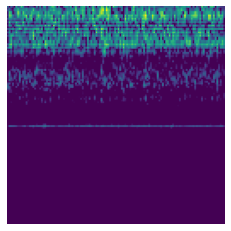

In [10]:
imagen = DATASET_PATH + '\\img4.png'
#imagen = 'imagen_capturada.png'
imagen_rgb = mpimg.imread(imagen) # para visualizar la imagen
plt.axis('off')
plt.imshow(imagen_rgb);

In [11]:
imagenMod = load_img(imagen, target_size=(128,128))
imagenMod = img_to_array(imagenMod)
imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

#### Prediccion

In [12]:
np.set_printoptions(precision=4, suppress=True)
pred = model.predict(imagenMod).astype("float32")
pred

array([[0.8079, 0.0039, 0.0044, 0.0038, 0.0212, 0.003 , 0.124 , 0.003 ,
        0.0044, 0.0093, 0.0151]], dtype=float32)

In [13]:
clases[np.argmax(pred)]

'0807  BENTEVEO COMÚN'

In [14]:
print(clases)

['0000  RUIDO', '0413  COTORRA', '0562  CARPINTERO REAL', '0625  HORNERO', '0807  BENTEVEO COMÚN', '0879  GOLONDRINA DOMÉSTICA', '0899  ZORZAL COLORADO', '0903  CALANDRIA CALANDRE', '1024  JILGUERO DORADO', '1062  GORRIÓN', '1070  BOYERITO']


## Obtener audio de mic para prediccion

In [15]:
os.chdir(cwd + '\\audio_imagen\\')

#### Abrimos el canal de audio con los parámeteros de configuración

In [16]:
def Bucle(tiempo_en_segundos, inicial):
    return tiempo_en_segundos > time.time()-inicial

In [17]:
class coefs:
        
    sr = 44100               # librosa sample rate input
    sec = 5                  # seconds   
    sshape = (128, 128)       # height x width
    fmin = 500               # spectrum min frequency
    fmax = 12500             # spectrum max frequency
    

In [18]:
def escucha_predice(FORMAT = pyaudio.paInt16, CHANNELS = 1, RATE = 44100, CHUNK = 1024, SECONDS = 20, bucle = 15, umbral = 0.9, clases=clases ):     
    '''
    FORMAT: pyaudio.paInt16       # Formato de lectura INT 16 bits
    CHANNELS = 1                  # 1 mono, 2 stereo
    RATE = 44100                  # Frecuencia de muestreo típica para audio
    CHUNK = 2048                  # Tamaño del paquete a procesar  (samples per data frame)
    SECONDS = 5                   # Tiempo en segundos
    '''

    acum_pred = [] 
    acum_indx = [] 
    inicial=time.time()
    while Bucle(bucle, inicial):
    
        # Instanciar PyAudio
        py_audio = pyaudio.PyAudio()

        # Instanciamos objeto de toma de audio
        stream = py_audio.open( format = FORMAT, channels = CHANNELS, rate = RATE, input=True, frames_per_buffer= CHUNK )

        # Inicializar arreglo para almacenar frames
        frames = []
        
        # Iniciamos ESCUCHA
        print("Escuchando...")


        # Almaceno data en chunks para el tiempo=duracion
        for i in range(0, int(RATE/ CHUNK * SECONDS)):
            data = stream.read(CHUNK)                         # Leemos paquetes de longitud CHUNK
            frames.append(data)

        # Detenemos servicios
        stream.stop_stream()             
        stream.close()
        py_audio.terminate()
        print("Stop.")

        
    #------------------------------------------------------------------------------------------------------------------   

        # Grabar audio a disco
        sound_file = wave.open("audio_captur.wav", 'wb')
        sound_file.setnchannels(1)
        sound_file.setsampwidth(py_audio.get_sample_size(pyaudio.paInt16))
        sound_file.setframerate(44100)
        sound_file.writeframes(b''.join(frames))
        sound_file.close()

    #-----------------------------------------------------------------------------------------------------------------
        
        # Cargar audio grabado
        audio, _ = librosa.load("audio_captur.wav", sr=None)
        
        for n in range(5):
            start = np.random.randint(1, len(audio)-(coefs.sec * coefs.sr))
            chunk = audio[start:start + coefs.sec * coefs.sr]

            # Espectrograma para cada segmento de audio -------------------------
            hop_length = int(coefs.sec * coefs.sr / (coefs.sshape[1] - 1))
            mel_spec = librosa.feature.melspectrogram(y = chunk, 
                                                      sr = coefs.sr, 
                                                      n_fft = 1024, 
                                                      hop_length = hop_length, 
                                                      n_mels = coefs.sshape[0], 
                                                      fmin = coefs.fmin, 
                                                      fmax = coefs.fmax)

            mel_spec = librosa.power_to_db(mel_spec**2, ref=np.max) 

            # Normalize
            mel_spec -= mel_spec.min()
            mel_spec /= mel_spec.max()

            # Grabar imagen ------------------------------------------------------
            im = Image.fromarray(mel_spec * 255.0).convert("L")
            im.save(f'img{n}.png')

            imagenMod = load_img(f'img{n}.png', target_size=(128,128))
            imagenMod = img_to_array(imagenMod)
            imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

            # Prediccion
            pred = model.predict(imagenMod).astype("float32")
        
            # Acumular indices
            acum_indx.append(np.argmax(pred))
            
            # Acumular predicciones
            acum_pred.append(pred[0][np.argmax(pred)])
            
            # Procesar predicciones y presentar
            unicos, cuenta = np.unique(acum_indx, return_counts=True)
            

        print("###################################")
        if len(acum_indx) > len(unicos) or len(unicos)==1:

            prob = c = 0
            for i in range(len(acum_indx)):
                if acum_indx[i] == unicos[np.argmax(cuenta)]:
                    prob += acum_pred[i]
                    c = c+1
            prob /= c
            if prob >= umbral:
                print(clases[unicos[np.argmax(cuenta)]][6:], end="")
                print(f"  Probabilidad: {round(prob,4)}")
            else:
                print(f"No se puede predecir con umbral >= {umbral}")
        else:
            print("No se puede predecir")

        print(acum_indx)
        print("###################################")
        print()

    
    return [acum_pred, acum_indx]

In [25]:
acum_pred, acum_indx = escucha_predice(bucle = 20, umbral = 0.5)

Escuchando...
Stop.
###################################
GORRIÓN  Probabilidad: 0.845
[9, 9, 9, 9, 9]
###################################



In [19]:
acum_pred

[0.3826335, 0.7164472, 0.6039993, 0.5162718, 0.43781266]

In [22]:
clases[10]

'1070  BOYERITO'